In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix 

# Loading Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot = True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


# Printing the Division of labels

In [3]:
print("Size of")
print("Length of Training-set \t {}".format(len(data.train.labels)))
print("Length of Testing-set \t {}".format(len(data.test.labels)))
print("Length of Validation-set \t {}".format(len(data.validation.labels)))

Size of
Length of Training-set 	 55000
Length of Testing-set 	 10000
Length of Validation-set 	 5000


The data is set to one hot encoding scheme.

In [4]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

# Calculating the Class numbers

In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [6]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [7]:
# MNIST images are 28 pixels in each dimension.
image_size = 28
image_size_flat = image_size * image_size
image_shape = (image_size,image_size)
num_classes = 10

In [8]:
def plot_images(images,cls_true,cls_pred = None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(image_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i],cls_pred[i])            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

# Testing for plots

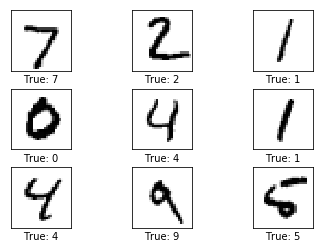

In [9]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images,cls_true=cls_true)

### Building the computational graph

In [10]:
x = tf.placeholder(tf.float32,[None,image_size_flat])

In [11]:
y_true = tf.placeholder(tf.float32,[None,num_classes])

In [12]:
y_true_cls = tf.placeholder(tf.int64,[None])

In [13]:
weights = tf.Variable(tf.zeros([image_size_flat, num_classes]))

In [14]:
biases = tf.Variable(tf.zeros([num_classes]))

multiplies the images in the placeholder variable x with the weights and then adds the biases.

In [15]:
logits = tf.matmul(x,weights) + biases

In [16]:
y_pred = tf.nn.softmax(logits)

In [17]:
y_pred_cls = tf.argmax(y_pred,dimension=1)

In [18]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                       labels=y_true)

In [19]:
cost = tf.reduce_mean(cross_entropy)

In [20]:
optimizer = tf.train.AdagradOptimizer(learning_rate=0.7).minimize(cost)

In [21]:
correct_prediction = tf.equal(y_pred_cls,y_true_cls)

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

### Running TensorFlow

TensorFlow Sessions are created and are used to execute the graph.

In [23]:
session = tf.Session()

In [24]:
session.run(tf.global_variables_initializer())

In [25]:
batch_size = 1000

In [26]:
def optimize(num_iterations):
    for i in range(num_iterations):
#         Get a batch of training examples.
#         x_batch now holds a batch of images and
#         y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

In [27]:
feed_dict_test = {x: data.test.images,
                 y_true: data.test.labels,
                 y_true_cls: data.test.cls}

In [28]:
def print_accuracy():
    acc = session.run(accuracy,feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [29]:
def print_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls,feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                         y_pred=cls_pred)
    print(cm)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [30]:
def plt_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                   feed_dict = feed_dict_test)
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images=images[0:9],
              cls_true = cls_true[0:9],
              cls_pred= cls_pred[0:9])

In [31]:
def plt_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    fig, axes = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        if i<10:
            image = w[:,i].reshape(image_shape)
            ax.set_xlabel("Weights:{0}".format(i))
            ax.imshow(image,vmin=w_min,vmax=w_max,
                     cmap = 'seismic')
        ax.set_xticks([])
        ax.set_yticks([])

In [32]:
print_accuracy()

Accuracy on test-set: 9.8%


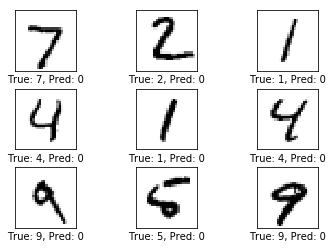

In [33]:
plt_example_errors()

In [34]:
optimize(num_iterations=1)

In [35]:
print_accuracy()

Accuracy on test-set: 49.3%


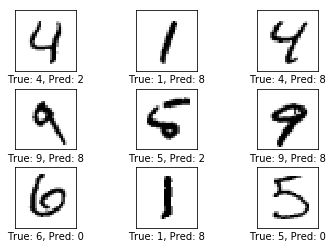

In [36]:
plt_example_errors()

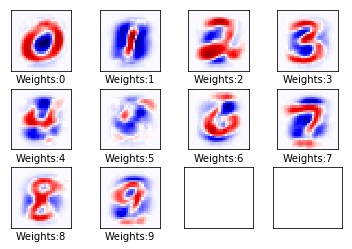

In [37]:
plt_weights()

In [38]:
optimize(num_iterations = 9)

In [39]:
print_accuracy()

Accuracy on test-set: 69.9%


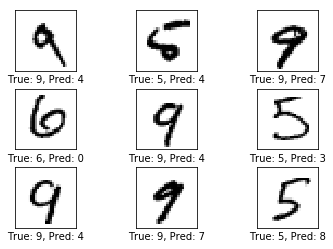

In [40]:
plt_example_errors()

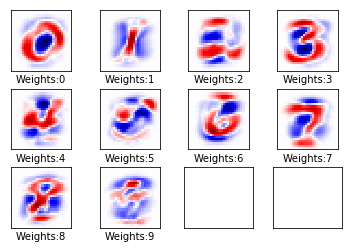

In [41]:
plt_weights()

In [42]:
optimize(num_iterations=990)

In [43]:
print_accuracy()

Accuracy on test-set: 92.1%


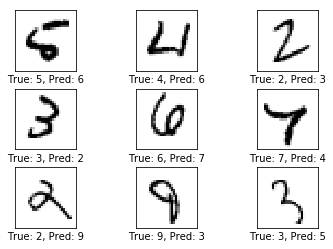

In [44]:
plt_example_errors()

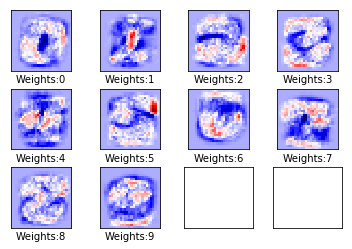

In [45]:
plt_weights()

[[ 964    0    0    2    0    6    5    2    1    0]
 [   0 1107    2    3    0    1    4    2   16    0]
 [   8    9  885   35   10    4   14   14   50    3]
 [   3    0    8  937    0   17    3   14   21    7]
 [   1    2    3    2  917    0   11    5    9   32]
 [  10    1    2   49   10  757   16   10   31    6]
 [  12    3    3    2    9   14  909    3    3    0]
 [   3    7   15   12    6    1    0  959    3   22]
 [   8    6    4   27    9   20    9   13  874    4]
 [  12    5    1   12   27    6    0   32    9  905]]


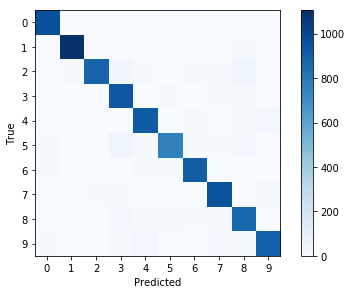

In [46]:
print_confusion_matrix()

In [47]:
session.close()